# Modelo 3: Red Neuronal Híbrida (Embedding + Dense)

Este notebook implementa una arquitectura de **Red Neuronal de dos ramas** utilizando Keras (TensorFlow).

**Estrategia:**
1. **Rama de Texto:** Utiliza una capa de `TextVectorization` y `Embedding` para aprender representaciones vectoriales de las palabras.
2. **Rama Numérica:** Procesa las *meta-features* (Mean Encoding, One-Hot Encoding, conteos) normalizadas.
3. **Concatenación:** Ambas ramas se unen para la clasificación final.

**Objetivo:** Superar 0.80 de F1 Score en validación.

## Imports

In [ ]:
# Standard
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator

# Deep Learning (Keras/TensorFlow)
import tensorflow as tf
from tensorflow.keras import models, callbacks, optimizers, Input
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.utils import set_random_seed


# NLP (Spacy para lematización previa)
import spacy
from spacy.cli import download
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## Constantes y Configuración

In [26]:
COLOR_NO_DISASTER = '#3498db'
COLOR_DISASTER = '#e74c3c'
COLOR_GENERAL = '#95a5a6'

SEED = 42
set_random_seed(SEED)
np.random.seed(SEED)

# Hiperparámetros de Texto
MAX_TOKENS = 10000  # Vocabulario máximo
SEQUENCE_LENGTH = 40  # Longitud máxima del tweet
EMBEDDING_DIM = 50    # Dimensión de los vectores de palabras

## Carga de Datos y Preprocesamiento Inicial

In [27]:
data_path = pathlib.Path("../.data/raw")
df = pd.read_csv(data_path / "train.csv")
test_df = pd.read_csv(data_path / "test.csv")

# Limpieza básica y Lematización
def preprocess_text(df):
    df = df.copy()
    # Lematización con Spacy
    df['clean_text'] = df['text'].astype(str).str.lower().apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
    
    # Extraer features básicas antes de perder info
    df['word_count'] = df['text'].str.split().str.len()
    df['char_count'] = df['text'].str.len()
    df['hashtag_count'] = df['text'].str.count(r'#')
    df['mention_count'] = df['text'].str.count(r'@')
    df['url_count'] = df['text'].str.count(r'http')
    
    # Keyword Cleaning
    df['keyword'] = df['keyword'].fillna('unknown')
    
    # Location cleaning (binaria)
    df['has_location'] = df['location'].notna().astype(int)
    
    return df

print("Preprocesando textos (esto puede tardar un poco por Spacy)...")
df = preprocess_text(df)
test_df = preprocess_text(test_df)
print("Preprocesamiento completado.")

Preprocesando textos (esto puede tardar un poco por Spacy)...
Preprocesamiento completado.
Preprocesamiento completado.


## Split, Mean Encoding y Scaling

Es crítico realizar el **Mean Encoding** y el **Scaling** *después* del split para evitar Data Leakage.

In [28]:
# Split Train/Validation
X = df.drop(columns=['target'])
y = df['target'].values

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

print(f"Train shape: {X_train_raw.shape}, Val shape: {X_val_raw.shape}")

# --- 1. Mean Encoding (Keyword) ---
# Calculamos medias SOLO en Train
keyword_means = X_train_raw.assign(target=y_train).groupby('keyword')['target'].mean()
global_mean = y_train.mean()

# Mapeamos a Train y Val
X_train_raw['keyword_encoded'] = X_train_raw['keyword'].map(keyword_means).fillna(global_mean)
X_val_raw['keyword_encoded'] = X_val_raw['keyword'].map(keyword_means).fillna(global_mean)
test_df['keyword_encoded'] = test_df['keyword'].map(keyword_means).fillna(global_mean)

# --- 2. One Hot Encoding (Top Keywords) ---
top_k = 20
top_keywords = X_train_raw['keyword'].value_counts().head(top_k).index

def apply_ohe_keyword(series, top_keys):
    return series.apply(lambda x: x if x in top_keys else 'other')

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_kw_top = apply_ohe_keyword(X_train_raw['keyword'], top_keywords).values.reshape(-1, 1)
val_kw_top = apply_ohe_keyword(X_val_raw['keyword'], top_keywords).values.reshape(-1, 1)
test_kw_top = apply_ohe_keyword(test_df['keyword'], top_keywords).values.reshape(-1, 1)

X_train_ohe = ohe.fit_transform(train_kw_top)
X_val_ohe = ohe.transform(val_kw_top)
X_test_ohe = ohe.transform(test_kw_top)

# --- 3. Numerical Scaling (StandardScaler) ---
num_cols = ['word_count', 'char_count', 'hashtag_count', 'mention_count', 'url_count', 'keyword_encoded', 'has_location']
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train_raw[num_cols])
X_val_num = scaler.transform(X_val_raw[num_cols])
X_test_num_scaled = scaler.transform(test_df[num_cols])

# Concatenar features numéricas + OHE
X_train_meta = np.hstack([X_train_num, X_train_ohe])
X_val_meta = np.hstack([X_val_num, X_val_ohe])
X_test_meta = np.hstack([X_test_num_scaled, X_test_ohe])

# Preparar Textos (Solo el array de strings)
X_train_text = X_train_raw['clean_text'].values
X_val_text = X_val_raw['clean_text'].values
X_test_text = test_df['clean_text'].values

print(f"Meta Features Shape: {X_train_meta.shape}")

Train shape: (6090, 11), Val shape: (1523, 11)
Meta Features Shape: (6090, 28)


## Arquitectura del Modelo

Usaremos **TextVectorization** para convertir texto a secuencias de enteros y una capa **Embedding** entrenable.

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 40)        │          0 │ text_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 50)    │    500,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 50)        │          0 │ embedding[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │        928 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      3,264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_19[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 96)        │          0 │ dropout_18[0][0], │
│ (Concatenate)       │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      6,208 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 510,593 (1.95 MB)

 Trainable params: 510,529 (1.95 MB)

 Non-trainable params: 64 (256.00 B)

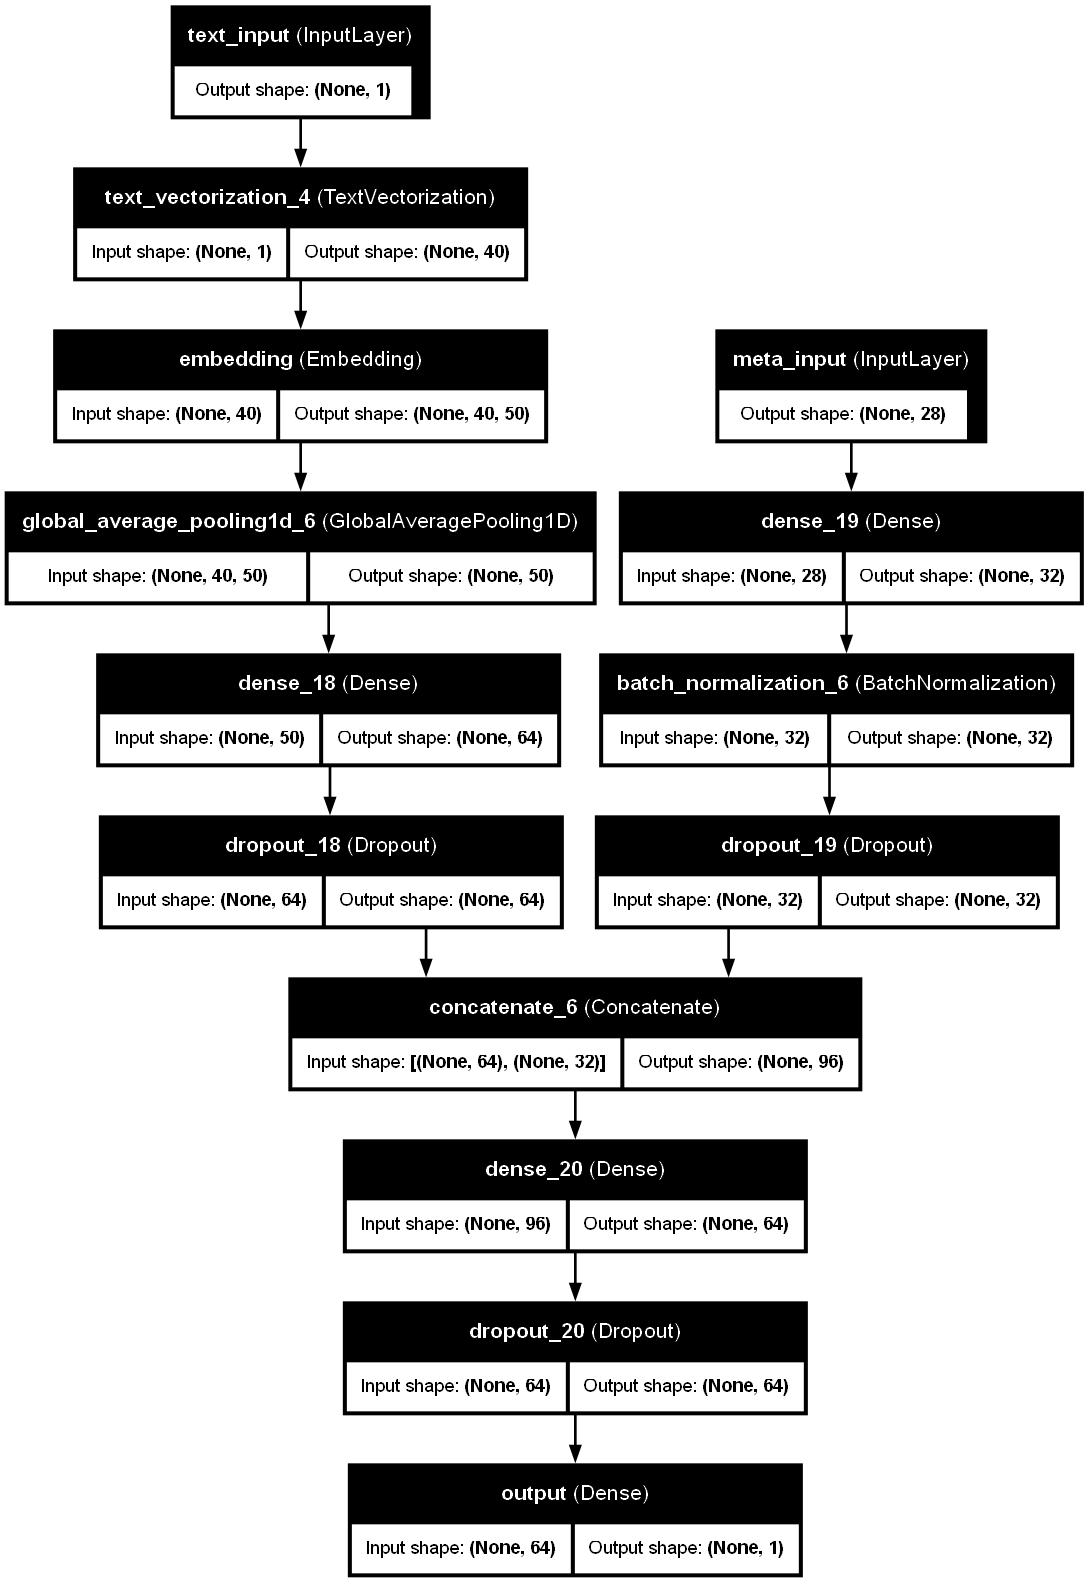

In [29]:
# 1. Adaptar TextVectorization solo al train set
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_sequence_length=SEQUENCE_LENGTH)
vectorizer.adapt(X_train_text)

def build_model(meta_dim):
    # --- Rama de Texto ---
    text_input = Input(shape=(1,), dtype=tf.string, name='text_input')
    x = vectorizer(text_input)
    x = Embedding(input_dim=MAX_TOKENS, output_dim=EMBEDDING_DIM, name='embedding')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # --- Rama Numérica (Meta) ---
    meta_input = Input(shape=(meta_dim,), name='meta_input')
    y = Dense(32, activation='relu')(meta_input)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)
    
    # --- Concatenación ---
    concat = Concatenate()([x, y])
    z = Dense(64, activation='relu')(concat)
    z = Dropout(0.5)(z)
    output = Dense(1, activation='sigmoid', name='output')(z)
    
    model = models.Model(inputs=[text_input, meta_input], outputs=output)
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['AUC'])
    return model

model = build_model(meta_dim=X_train_meta.shape[1])
model.summary()

# Visualizar arquitectura del modelo
tf.keras.utils.plot_model(
    model, 
    to_file='neural_network_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # Top to Bottom
    expand_nested=True,
    dpi=96
)

## Entrenamiento
Usamos **EarlyStopping** y **ReduceLROnPlateau** para optimizar el entrenamiento.

Iniciando entrenamiento...
Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7180 - loss: 0.6394 - val_AUC: 0.8174 - val_loss: 0.5450 - learning_rate: 0.0010
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.7180 - loss: 0.6394 - val_AUC: 0.8174 - val_loss: 0.5450 - learning_rate: 0.0010
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7816 - loss: 0.5621 - val_AUC: 0.8235 - val_loss: 0.5119 - learning_rate: 0.0010
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.7816 - loss: 0.5621 - val_AUC: 0.8235 - val_loss: 0.5119 - learning_rate: 0.0010
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8004 - loss: 0.5396 - val_AUC: 0.8335 - val_loss: 0.4919 - learning_rate: 0.0010
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8004 - loss: 0.5396 - val_AUC: 0.8335 - val_loss: 0.4919 - learning_rate: 0.0010
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.8384 - loss: 0.4893 - val_AUC: 0.8604 - val_loss: 0.4638 - l

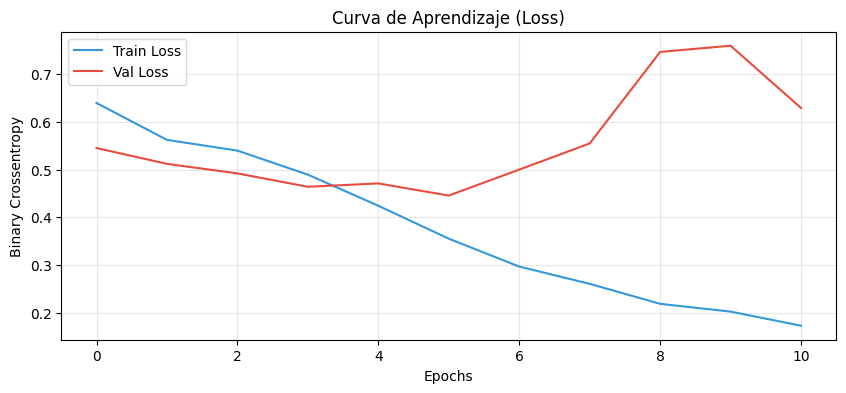

In [30]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

print("Iniciando entrenamiento...")
history = model.fit(
    x={'text_input': X_train_text, 'meta_input': X_train_meta},
    y=y_train,
    validation_data=({'text_input': X_val_text, 'meta_input': X_val_meta}, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', color=COLOR_NO_DISASTER)
plt.plot(history.history['val_loss'], label='Val Loss', color=COLOR_DISASTER)
plt.title('Curva de Aprendizaje (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Análisis y Evaluación (Curva ROC, Confusion Matrix, Feature Importance)

Buscamos el mejor umbral (threshold) para maximizar F1.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Mejor Threshold: 0.610
Mejor F1 Score (Validación): 0.7834

Mejor Threshold: 0.610
Mejor F1 Score (Validación): 0.7834


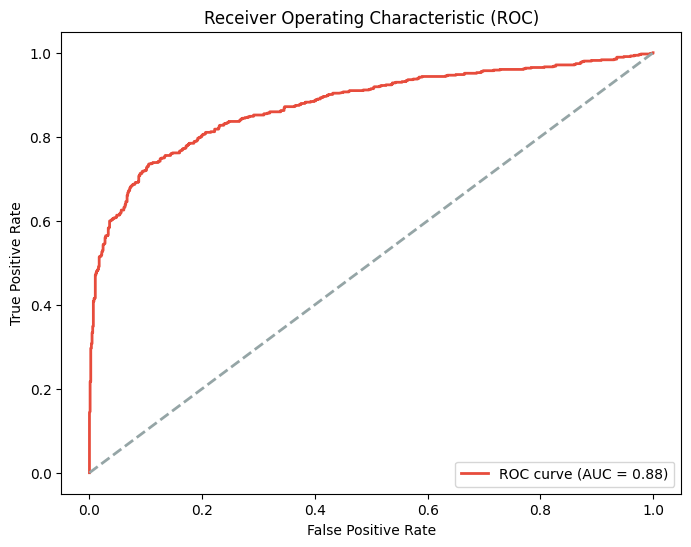

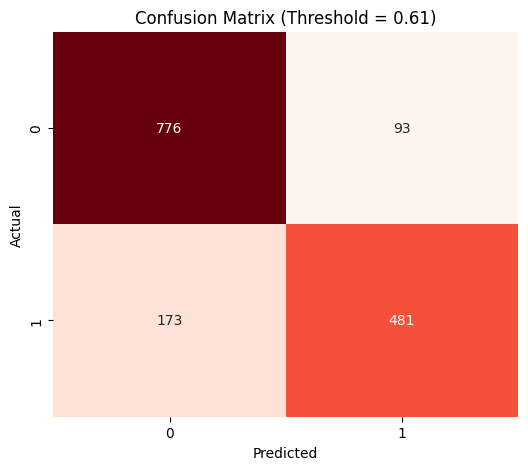

Calculando Permutation Importance para features numéricas...


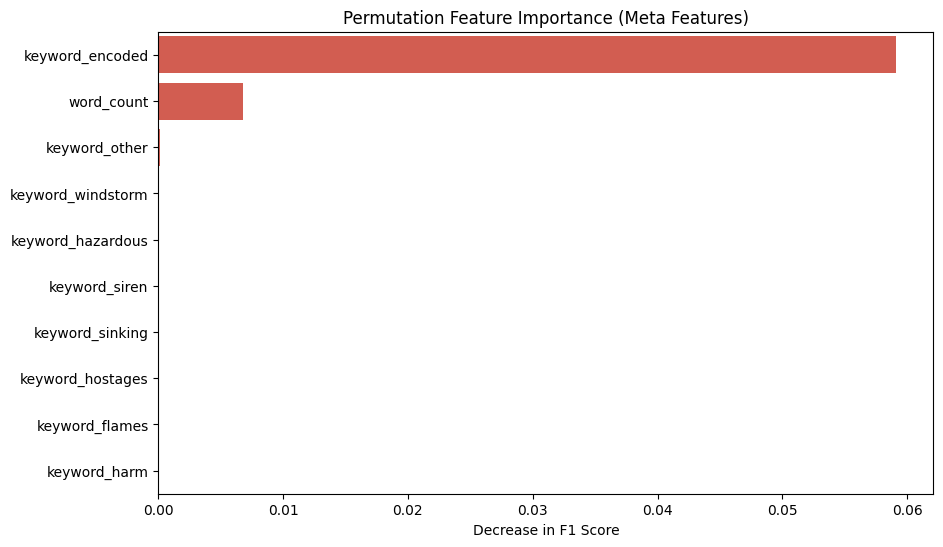

In [31]:
# Predicciones (Probabilidades)
y_val_probs = model.predict({'text_input': X_val_text, 'meta_input': X_val_meta}).flatten()

# 1. Optimizar Threshold para F1
best_thresh = 0.5
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    preds = (y_val_probs > thresh).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"\nMejor Threshold: {best_thresh:.3f}")
print(f"Mejor F1 Score (Validación): {best_f1:.4f}")

# 2. Curva ROC
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=COLOR_DISASTER, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color=COLOR_GENERAL, lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# 3. Matriz de Confusión
y_val_pred = (y_val_probs > best_thresh).astype(int)
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Confusion Matrix (Threshold = {best_thresh:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. Feature Importance (Meta Features)
# Usamos Permutation Importance sobre las features numéricas/OHE para ver qué pesa más
print("Calculando Permutation Importance para features numéricas...")


class KerasMetaWrapper(BaseEstimator):
    def __init__(self, model, text_data, threshold=0.5):
        self.model = model
        self.text_data = text_data
        self.threshold = threshold
    
    def fit(self, X, y=None):
        # No necesitamos fit, el modelo ya está entrenado
        return self
    
    def predict(self, X_meta):
        # X_meta es el input que permuta sklearn
        probs = self.model.predict({'text_input': self.text_data, 'meta_input': X_meta}, verbose=0)
        return (probs > self.threshold).astype(int).flatten()
    
    def score(self, X_meta, y):
        return f1_score(y, self.predict(X_meta))

# Usamos un subset de validación para acelerar
subset_idx = np.random.choice(len(X_val_meta), 500, replace=False)
wrapper = KerasMetaWrapper(model, X_val_text[subset_idx], threshold=best_thresh)

results = permutation_importance(wrapper, X_val_meta[subset_idx], y_val[subset_idx], scoring='f1', n_repeats=5, random_state=SEED)

# Nombres de features (Numéricas + OHE)
feat_names = num_cols + list(ohe.get_feature_names_out(['keyword']))

# Graficar Top 10
sorted_idx = results.importances_mean.argsort()[::-1][:10]
plt.figure(figsize=(10, 6))
sns.barplot(x=results.importances_mean[sorted_idx], y=np.array(feat_names)[sorted_idx], color=COLOR_DISASTER)
plt.title("Permutation Feature Importance (Meta Features)")
plt.xlabel("Decrease in F1 Score")
plt.show()

## Generación de Submission
Entrenamos con el 100% de los datos (Train + Val) para la predicción final.

In [32]:
# Concatenar datos
X_full_text = np.concatenate([X_train_text, X_val_text])
X_full_meta = np.vstack([X_train_meta, X_val_meta])
y_full = np.concatenate([y_train, y_val])

# Re-entrenar modelo limpio
final_model = build_model(meta_dim=X_full_meta.shape[1])
final_model.fit(
    x={'text_input': X_full_text, 'meta_input': X_full_meta},
    y=y_full,
    epochs=20,  # Usamos un número fijo razonable basado en el early stopping anterior
    batch_size=32,
    verbose=0
)

# Predecir Test
y_test_probs = final_model.predict({'text_input': X_test_text, 'meta_input': X_test_meta}, verbose=0).flatten()
y_test_pred = (y_test_probs > best_thresh).astype(int)

# Guardar
submission = pd.DataFrame({'id': test_df['id'], 'target': y_test_pred})
submission_path = pathlib.Path("../.data/submission")
submission_path.mkdir(parents=True, exist_ok=True)
submission.to_csv(submission_path / "neural_network_submission.csv", index=False)

print(f"Submission guardada en {submission_path / 'neural_network_submission.csv'}")

Submission guardada en ..\.data\submission\neural_network_submission.csv
